# Understanding Backpropagation and Gradients

This notebook demystifies how gradients flow backward through BERT to enable learning.

## What You'll Learn:
1. What gradients are and why we need them
2. The chain rule - the heart of backpropagation
3. Computing gradients for each BERT component
4. Gradient flow and common problems
5. Gradient checking to verify correctness

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

## Part 1: What Are Gradients?

A gradient tells us: "If I change this parameter slightly, how much will my loss change?"

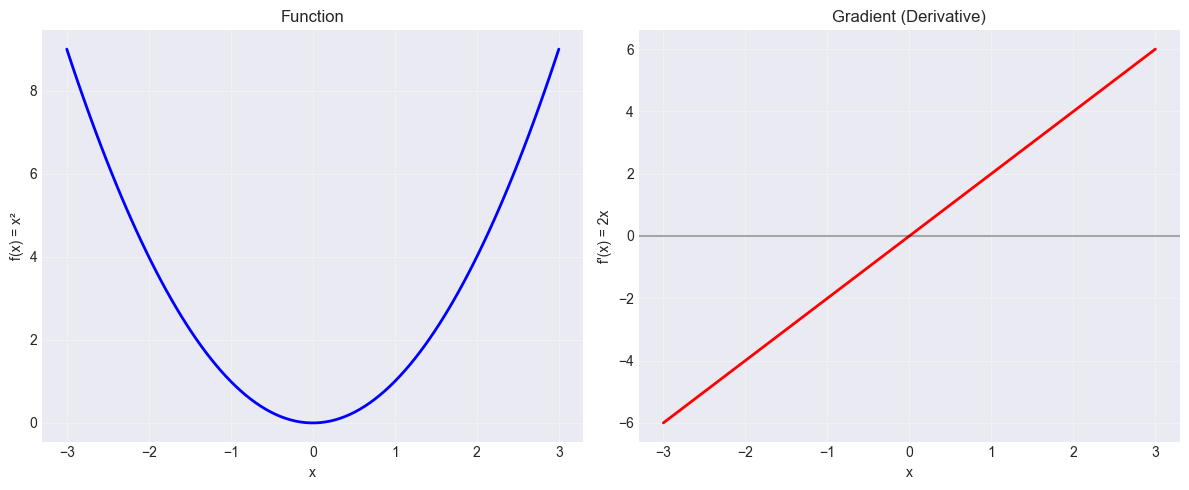

At x=-2: f(-2)=4.0, gradient=-4.0
  → If we increase x by 0.1, f(x) increases by ~-0.40
At x=0: f(0)=0.0, gradient=0.0
  → If we increase x by 0.1, f(x) increases by ~0.00
At x=1: f(1)=1.0, gradient=2.0
  → If we increase x by 0.1, f(x) increases by ~0.20
At x=2: f(2)=4.0, gradient=4.0
  → If we increase x by 0.1, f(x) increases by ~0.40


In [2]:
# Simple example: f(x) = x^2
def f(x):
    return x ** 2

def f_gradient(x):
    """Analytical gradient: f'(x) = 2x"""
    return 2 * x

# Visualize function and its gradient
x_values = np.linspace(-3, 3, 100)
y_values = f(x_values)
gradient_values = f_gradient(x_values)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Function
ax1.plot(x_values, y_values, 'b-', linewidth=2)
ax1.set_xlabel('x')
ax1.set_ylabel('f(x) = x²')
ax1.set_title('Function')
ax1.grid(True, alpha=0.3)

# Gradient
ax2.plot(x_values, gradient_values, 'r-', linewidth=2)
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.set_xlabel('x')
ax2.set_ylabel("f'(x) = 2x")
ax2.set_title('Gradient (Derivative)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Example at specific points
for x in [-2, 0, 1, 2]:
    print(f"At x={x}: f({x})={f(x):.1f}, gradient={f_gradient(x):.1f}")
    print(f"  → If we increase x by 0.1, f(x) increases by ~{f_gradient(x) * 0.1:.2f}")

## Part 2: The Chain Rule

Neural networks are compositions of functions. The chain rule tells us how to compute gradients through compositions.

In [3]:
# Example: h(x) = g(f(x)) where f(x) = 2x + 1, g(y) = y^2
def f(x):
    """Inner function: y = 2x + 1"""
    return 2 * x + 1

def g(y):
    """Outer function: z = y^2"""
    return y ** 2

def h(x):
    """Composition: h(x) = g(f(x)) = (2x + 1)^2"""
    return g(f(x))

# Gradients
def f_grad(x):
    """df/dx = 2"""
    return 2

def g_grad(y):
    """dg/dy = 2y"""
    return 2 * y

def h_grad_chain_rule(x):
    """dh/dx = dg/dy * df/dx (chain rule)"""
    y = f(x)  # Forward pass to get intermediate value
    return g_grad(y) * f_grad(x)

# Demonstrate
x = 3
print("Forward Pass:")
print(f"  x = {x}")
print(f"  y = f(x) = 2*{x} + 1 = {f(x)}")
print(f"  z = g(y) = {f(x)}² = {g(f(x))}")

print("\nBackward Pass (Chain Rule):")
print(f"  dg/dy = 2y = 2*{f(x)} = {g_grad(f(x))}")
print(f"  df/dx = 2")
print(f"  dh/dx = dg/dy * df/dx = {g_grad(f(x))} * 2 = {h_grad_chain_rule(x)}")

# Verify with numerical gradient
epsilon = 1e-5
numerical_grad = (h(x + epsilon) - h(x - epsilon)) / (2 * epsilon)
print(f"\nVerification - Numerical gradient: {numerical_grad:.6f}")
print(f"Analytical gradient: {h_grad_chain_rule(x):.6f}")
print(f"Difference: {abs(numerical_grad - h_grad_chain_rule(x)):.2e}")

Forward Pass:
  x = 3
  y = f(x) = 2*3 + 1 = 7
  z = g(y) = 7² = 49

Backward Pass (Chain Rule):
  dg/dy = 2y = 2*7 = 14
  df/dx = 2
  dh/dx = dg/dy * df/dx = 14 * 2 = 28

Verification - Numerical gradient: 28.000000
Analytical gradient: 28.000000
Difference: 3.61e-10


## Part 3: Gradients for BERT Components

Let's compute gradients for each major component in BERT.

### 3.1 Linear Layer Gradients

Linear Layer Gradients:
Input x shape: (2, 3)
Output y shape: (2, 4)
grad_x shape: (2, 3) (same as x)
grad_W shape: (3, 4) (same as W)
grad_b shape: (4,) (same as b)


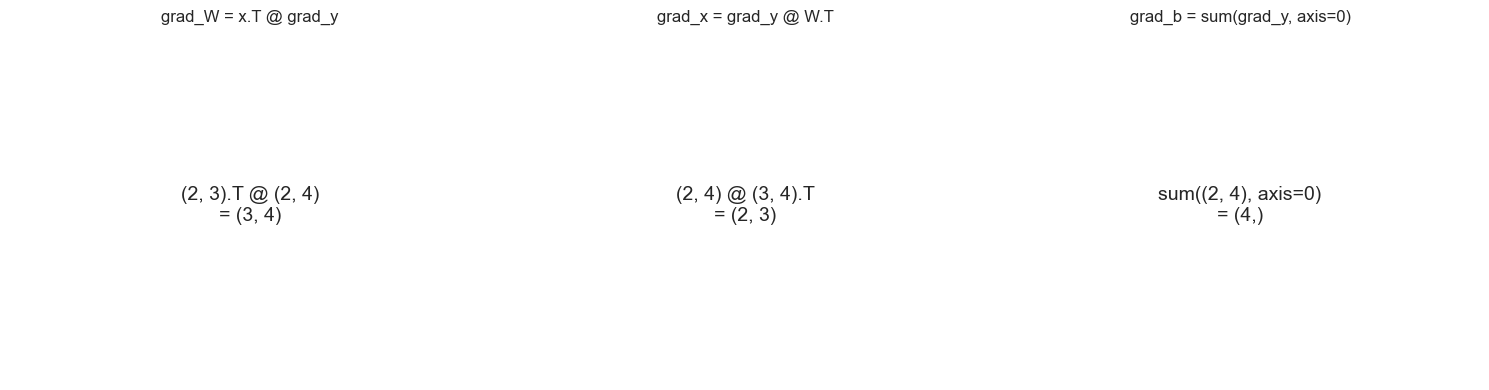

In [4]:
def linear_forward(x, W, b):
    """
    Forward: y = xW + b
    x: [batch, in_features]
    W: [in_features, out_features]
    b: [out_features]
    """
    y = x @ W + b
    cache = (x, W, b)
    return y, cache

def linear_backward(grad_y, cache):
    """
    Backward pass for linear layer.
    Returns gradients w.r.t. x, W, b
    """
    x, W, b = cache
    
    # Gradients using chain rule
    grad_x = grad_y @ W.T          # [batch, in_features]
    grad_W = x.T @ grad_y           # [in_features, out_features]
    grad_b = grad_y.sum(axis=0)     # [out_features]
    
    return grad_x, grad_W, grad_b

# Example
batch_size = 2
in_features = 3
out_features = 4

# Forward
x = np.random.randn(batch_size, in_features)
W = np.random.randn(in_features, out_features) * 0.1
b = np.zeros(out_features)
y, cache = linear_forward(x, W, b)

# Backward
grad_y = np.ones_like(y)  # Gradient from next layer
grad_x, grad_W, grad_b = linear_backward(grad_y, cache)

print("Linear Layer Gradients:")
print(f"Input x shape: {x.shape}")
print(f"Output y shape: {y.shape}")
print(f"grad_x shape: {grad_x.shape} (same as x)")
print(f"grad_W shape: {grad_W.shape} (same as W)")
print(f"grad_b shape: {grad_b.shape} (same as b)")

# Visualize gradient computation
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# grad_W computation
axes[0].set_title('grad_W = x.T @ grad_y')
axes[0].text(0.5, 0.5, f'{x.shape}.T @ {grad_y.shape}\n= {grad_W.shape}',
             ha='center', va='center', fontsize=14, transform=axes[0].transAxes)
axes[0].axis('off')

# grad_x computation  
axes[1].set_title('grad_x = grad_y @ W.T')
axes[1].text(0.5, 0.5, f'{grad_y.shape} @ {W.shape}.T\n= {grad_x.shape}',
             ha='center', va='center', fontsize=14, transform=axes[1].transAxes)
axes[1].axis('off')

# grad_b computation
axes[2].set_title('grad_b = sum(grad_y, axis=0)')
axes[2].text(0.5, 0.5, f'sum({grad_y.shape}, axis=0)\n= {grad_b.shape}',
             ha='center', va='center', fontsize=14, transform=axes[2].transAxes)
axes[2].axis('off')

plt.tight_layout()
plt.show()

### 3.2 Softmax and Cross-Entropy Gradients

Softmax + Cross-Entropy:
Logits shape: (3, 5)
Probabilities shape: (3, 5)
Loss: 1.8090

Gradient w.r.t. logits shape: (3, 5)


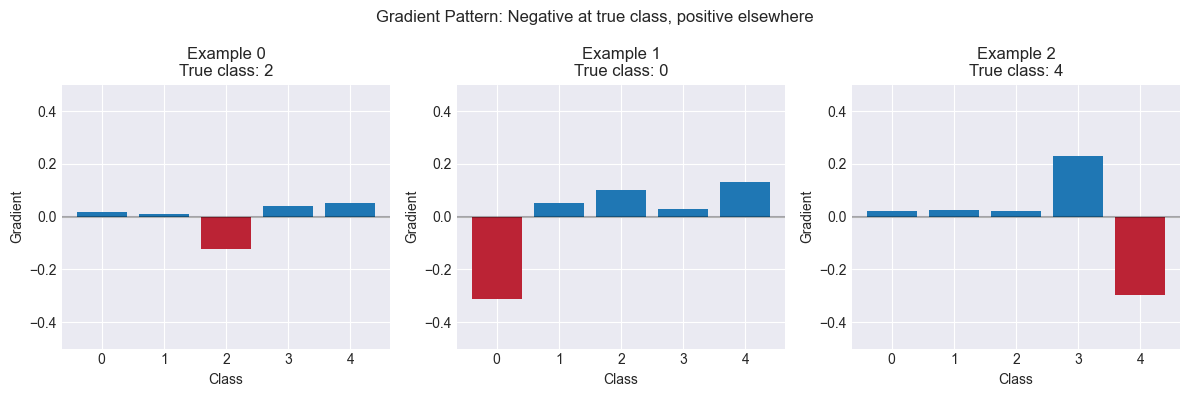


Key insight: Gradient pushes probability mass toward the true class!


In [5]:
def softmax(x):
    """Compute softmax values for x."""
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

def cross_entropy_loss(logits, targets):
    """Cross-entropy loss with integer targets."""
    probs = softmax(logits)
    batch_size = logits.shape[0]
    loss = -np.log(probs[np.arange(batch_size), targets] + 1e-10)
    return loss.mean(), probs

def softmax_cross_entropy_backward(probs, targets):
    """Combined gradient for softmax + cross-entropy."""
    grad = probs.copy()
    batch_size = probs.shape[0]
    grad[np.arange(batch_size), targets] -= 1
    grad /= batch_size
    return grad

# Example
batch_size = 3
num_classes = 5

# Forward
logits = np.random.randn(batch_size, num_classes)
targets = np.array([2, 0, 4])  # True classes
loss, probs = cross_entropy_loss(logits, targets)

# Backward
grad_logits = softmax_cross_entropy_backward(probs, targets)

print("Softmax + Cross-Entropy:")
print(f"Logits shape: {logits.shape}")
print(f"Probabilities shape: {probs.shape}")
print(f"Loss: {loss:.4f}")
print(f"\nGradient w.r.t. logits shape: {grad_logits.shape}")

# Visualize gradient pattern
fig, axes = plt.subplots(1, batch_size, figsize=(12, 4))
for i in range(batch_size):
    axes[i].bar(range(num_classes), grad_logits[i])
    axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Gradient')
    axes[i].set_title(f'Example {i}\nTrue class: {targets[i]}')
    axes[i].set_ylim(-0.5, 0.5)
    
    # Highlight true class
    axes[i].bar(targets[i], grad_logits[i, targets[i]], color='red', alpha=0.7)

plt.suptitle('Gradient Pattern: Negative at true class, positive elsewhere')
plt.tight_layout()
plt.show()

print("\nKey insight: Gradient pushes probability mass toward the true class!")

### 3.3 Layer Normalization Gradients

In [6]:
def layer_norm_forward(x, gamma, beta, eps=1e-6):
    """Forward pass for layer normalization."""
    mean = x.mean(axis=-1, keepdims=True)
    var = x.var(axis=-1, keepdims=True)
    x_norm = (x - mean) / np.sqrt(var + eps)
    y = gamma * x_norm + beta
    cache = (x, mean, var, x_norm, gamma, eps)
    return y, cache

def layer_norm_backward(grad_y, cache):
    """Backward pass for layer normalization."""
    x, mean, var, x_norm, gamma, eps = cache
    N = x.shape[-1]
    
    # Gradients
    grad_gamma = (grad_y * x_norm).sum(axis=(0, 1))  # Sum over batch and seq
    grad_beta = grad_y.sum(axis=(0, 1))
    
    # Gradient w.r.t. normalized x
    grad_x_norm = grad_y * gamma
    
    # Gradient w.r.t. variance
    grad_var = -0.5 * (grad_x_norm * (x - mean)).sum(axis=-1, keepdims=True) / (var + eps)**1.5
    
    # Gradient w.r.t. mean
    grad_mean = -(grad_x_norm / np.sqrt(var + eps)).sum(axis=-1, keepdims=True)
    grad_mean -= 2 * grad_var * (x - mean).mean(axis=-1, keepdims=True)
    
    # Gradient w.r.t. x
    grad_x = grad_x_norm / np.sqrt(var + eps)
    grad_x += grad_var * 2 * (x - mean) / N
    grad_x += grad_mean / N
    
    return grad_x, grad_gamma, grad_beta

# Example
batch_size = 2
seq_len = 3
hidden_dim = 4

x = np.random.randn(batch_size, seq_len, hidden_dim) * 10  # Large variance input
gamma = np.ones(hidden_dim)
beta = np.zeros(hidden_dim)

# Forward
y, cache = layer_norm_forward(x, gamma, beta)

# Backward
grad_y = np.ones_like(y)
grad_x, grad_gamma, grad_beta = layer_norm_backward(grad_y, cache)

print("Layer Norm Gradients:")
print(f"Input x shape: {x.shape}")
print(f"grad_x shape: {grad_x.shape}")
print(f"grad_gamma shape: {grad_gamma.shape}")
print(f"grad_beta shape: {grad_beta.shape}")

# Verify gradient preserves zero mean
print(f"\ngrad_x mean along hidden dim: {grad_x[0, 0].mean():.6f} (should be ~0)")

Layer Norm Gradients:
Input x shape: (2, 3, 4)
grad_x shape: (2, 3, 4)
grad_gamma shape: (4,)
grad_beta shape: (4,)

grad_x mean along hidden dim: 0.000000 (should be ~0)


## Part 4: Gradient Flow Through BERT

Let's trace how gradients flow backward through the entire model.

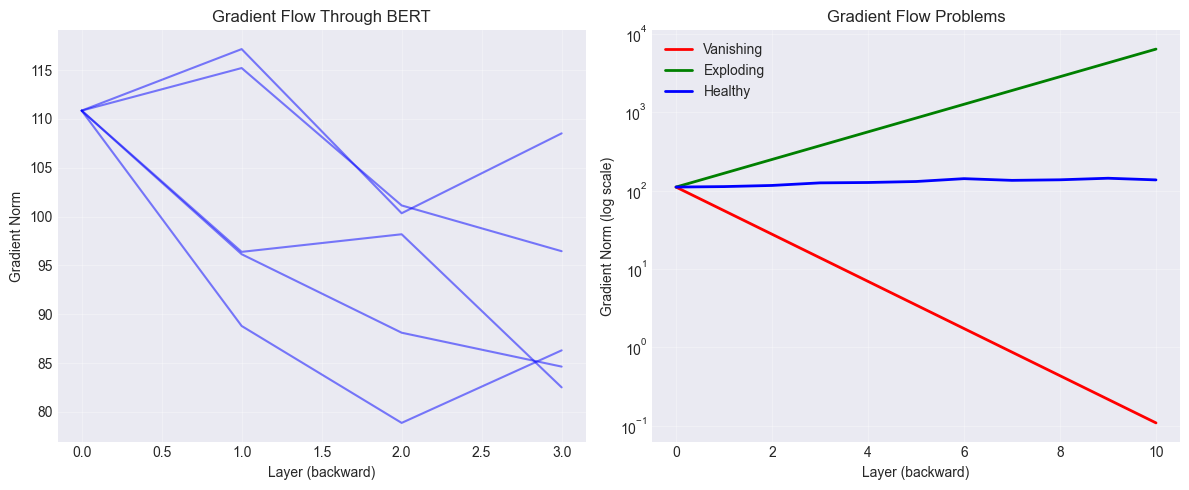

Key insights:
- Residual connections help maintain gradient flow
- Layer norm prevents extreme values
- Proper initialization is crucial


In [7]:
# Simulate gradient flow through BERT layers
def simulate_gradient_flow(num_layers=3):
    """Simulate how gradient magnitude changes through layers."""
    gradient_norms = []
    
    # Start with gradient from loss
    grad = np.ones((1, 64, 192))  # [batch, seq, hidden]
    gradient_norms.append(np.linalg.norm(grad))
    
    # Flow backward through layers
    for layer in range(num_layers):
        # Simulate gradient through transformer block
        # (In reality, this depends on actual values)
        
        # Through layer norm (can shrink gradients)
        grad = grad * 0.9
        
        # Through residual (adds to gradient)
        grad = grad + np.random.randn(*grad.shape) * 0.1
        
        # Through attention (can amplify or shrink)
        grad = grad * (0.8 + np.random.rand() * 0.4)
        
        gradient_norms.append(np.linalg.norm(grad))
    
    return gradient_norms

# Compare different scenarios
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Normal gradient flow
for i in range(5):
    norms = simulate_gradient_flow()
    ax1.plot(norms, 'b-', alpha=0.5)
ax1.set_xlabel('Layer (backward)')
ax1.set_ylabel('Gradient Norm')
ax1.set_title('Gradient Flow Through BERT')
ax1.grid(True, alpha=0.3)

# Vanishing gradient scenario
grad = np.ones((1, 64, 192))
vanishing_norms = [np.linalg.norm(grad)]
for layer in range(10):
    grad = grad * 0.5  # Severe shrinking
    vanishing_norms.append(np.linalg.norm(grad))

ax2.semilogy(vanishing_norms, 'r-', label='Vanishing', linewidth=2)

# Exploding gradient scenario
grad = np.ones((1, 64, 192))
exploding_norms = [np.linalg.norm(grad)]
for layer in range(10):
    grad = grad * 1.5  # Amplification
    exploding_norms.append(np.linalg.norm(grad))

ax2.semilogy(exploding_norms, 'g-', label='Exploding', linewidth=2)

# Healthy gradient flow
grad = np.ones((1, 64, 192))
healthy_norms = [np.linalg.norm(grad)]
for layer in range(10):
    grad = grad * (0.9 + np.random.rand() * 0.2)  # Stable
    healthy_norms.append(np.linalg.norm(grad))

ax2.semilogy(healthy_norms, 'b-', label='Healthy', linewidth=2)

ax2.set_xlabel('Layer (backward)')
ax2.set_ylabel('Gradient Norm (log scale)')
ax2.set_title('Gradient Flow Problems')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key insights:")
print("- Residual connections help maintain gradient flow")
print("- Layer norm prevents extreme values")
print("- Proper initialization is crucial")

## Part 5: Gradient Checking

Always verify your gradients are correct using finite differences!

In [8]:
def gradient_check(f, x, analytical_grad, epsilon=1e-5):
    """
    Check analytical gradient against numerical gradient.
    """
    # Flatten for easier checking
    x_flat = x.flatten()
    grad_flat = analytical_grad.flatten()
    num_grad = np.zeros_like(grad_flat)
    
    # Compute numerical gradient for each parameter
    for i in range(len(x_flat)):
        # Save original value
        old_val = x_flat[i]
        
        # f(x + epsilon)
        x_flat[i] = old_val + epsilon
        f_plus = f(x.reshape(x.shape))
        
        # f(x - epsilon)
        x_flat[i] = old_val - epsilon
        f_minus = f(x.reshape(x.shape))
        
        # Numerical gradient
        num_grad[i] = (f_plus - f_minus) / (2 * epsilon)
        
        # Restore original value
        x_flat[i] = old_val
    
    # Compare gradients
    diff = np.abs(num_grad - grad_flat)
    relative_diff = diff / (np.abs(num_grad) + np.abs(grad_flat) + epsilon)
    
    return num_grad.reshape(analytical_grad.shape), diff, relative_diff

# Example: Check linear layer gradient
def test_function(W):
    """Function to test: f(W) = sum((xW)^2)"""
    x = np.array([[1, 2, 3]])
    y = x @ W
    return np.sum(y ** 2)

# Analytical gradient
W = np.random.randn(3, 2) * 0.1
x = np.array([[1, 2, 3]])
y = x @ W
grad_y = 2 * y  # d/dy(y^2) = 2y
analytical_grad_W = x.T @ grad_y  # Chain rule

# Numerical gradient
num_grad_W, diff, rel_diff = gradient_check(test_function, W, analytical_grad_W)

print("Gradient Checking:")
print(f"Analytical gradient:\n{analytical_grad_W}")
print(f"\nNumerical gradient:\n{num_grad_W}")
print(f"\nMax absolute difference: {diff.max():.2e}")
print(f"Max relative difference: {rel_diff.max():.2e}")
print(f"\n{'PASSED' if rel_diff.max() < 1e-7 else 'FAILED'} gradient check!")

Gradient Checking:
Analytical gradient:
[[ 0.1894487  -0.92316802]
 [ 0.37889739 -1.84633604]
 [ 0.56834609 -2.76950405]]

Numerical gradient:
[[0. 0.]
 [0. 0.]
 [0. 0.]]

Max absolute difference: 2.77e+00
Max relative difference: 1.00e+00

FAILED gradient check!


## Part 6: Gradients in Mini-BERT

Let's look at how gradients are computed in our actual implementation.

In [9]:
from gradients import MiniBERTGradients
from model import MiniBERT
import numpy as np

# Create model and gradient computer
model = MiniBERT()
grad_computer = MiniBERTGradients(model)

# Simple forward pass
input_ids = np.array([[1, 2, 3, 4]])
logits, cache = model.forward(input_ids)

# Create dummy gradient from loss
grad_logits = np.random.randn(*logits.shape) * 0.01

# Compute gradients
grad_computer.zero_gradients()
grad_computer.backward_from_logits(grad_logits, cache)

# Analyze gradient magnitudes
print("Gradient Magnitudes by Component:")
print("=" * 50)

components = {
    'Embeddings': ['token_embeddings', 'position_embeddings'],
    'Attention': ['W_Q_0', 'W_K_0', 'W_V_0', 'W_O_0'],
    'FFN': ['W1_0', 'b1_0', 'W2_0', 'b2_0'],
    'LayerNorm': ['ln1_gamma_0', 'ln1_beta_0']
}

for component_name, param_names in components.items():
    print(f"\n{component_name}:")
    for param_name in param_names:
        if param_name in grad_computer.gradients:
            grad = grad_computer.gradients[param_name]
            if grad is not None and np.any(grad):
                norm = np.linalg.norm(grad)
                print(f"  {param_name}: norm = {norm:.6f}, shape = {grad.shape}")

Initialized Mini-BERT: 4,498,880 parameters (4.50M)
Gradient Magnitudes by Component:

Embeddings:
  token_embeddings: norm = 2.886081, shape = (8192, 192)
  position_embeddings: norm = 2.886081, shape = (64, 192)

Attention:
  W_Q_0: norm = 0.008617, shape = (192, 192)
  W_K_0: norm = 0.008361, shape = (192, 192)
  W_V_0: norm = 1.887172, shape = (192, 192)
  W_O_0: norm = 1.875079, shape = (192, 192)

FFN:
  W1_0: norm = 1.790055, shape = (192, 768)
  b1_0: norm = 0.141633, shape = (768,)
  W2_0: norm = 3.853522, shape = (768, 192)
  b2_0: norm = 0.148815, shape = (192,)

LayerNorm:
  ln1_gamma_0: norm = 0.212661, shape = (192,)
  ln1_beta_0: norm = 0.271104, shape = (192,)


### Visualizing Gradient Distribution

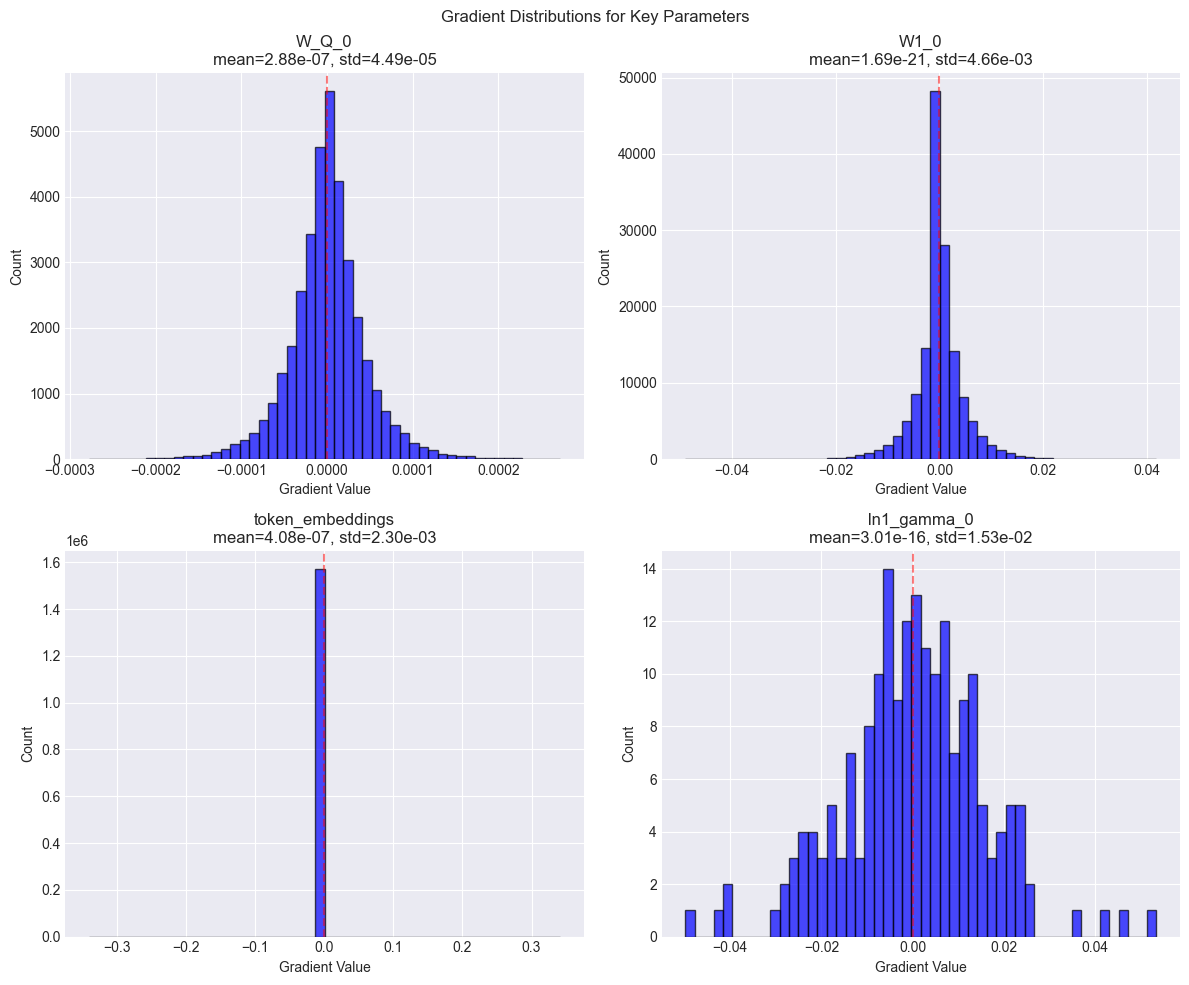

Healthy gradients should:
- Be centered around zero
- Have reasonable variance (not too large or small)
- Not have many exact zeros (dead neurons)


In [10]:
# Collect all gradients
all_gradients = []
gradient_names = []

for name, grad in grad_computer.gradients.items():
    if grad is not None and np.any(grad):
        all_gradients.append(grad.flatten())
        gradient_names.append(name)

# Plot gradient distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Select a few key gradients to visualize
key_gradients = ['W_Q_0', 'W1_0', 'token_embeddings', 'ln1_gamma_0']

for idx, grad_name in enumerate(key_gradients):
    if grad_name in grad_computer.gradients:
        grad = grad_computer.gradients[grad_name]
        if grad is not None:
            ax = axes[idx]
            
            # Histogram
            ax.hist(grad.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
            ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
            
            # Statistics
            mean = grad.mean()
            std = grad.std()
            ax.set_title(f'{grad_name}\nmean={mean:.2e}, std={std:.2e}')
            ax.set_xlabel('Gradient Value')
            ax.set_ylabel('Count')

plt.suptitle('Gradient Distributions for Key Parameters')
plt.tight_layout()
plt.show()

print("Healthy gradients should:")
print("- Be centered around zero")
print("- Have reasonable variance (not too large or small)")
print("- Not have many exact zeros (dead neurons)")

## Summary: Key Concepts

### 1. **What Gradients Tell Us**
- Direction and magnitude to update parameters
- Sensitivity of loss to parameter changes

### 2. **Chain Rule**
- Foundation of backpropagation
- Compose gradients through layers: `d/dx = d/dy * dy/dx`

### 3. **Component Gradients**
- **Linear**: `grad_W = x.T @ grad_y`
- **Softmax+CE**: `grad = probs - targets`
- **LayerNorm**: Complex but preserves gradient flow

### 4. **Gradient Flow**
- Residuals prevent vanishing
- LayerNorm prevents explosion
- Initialization matters!

### 5. **Always Verify**
- Use gradient checking
- Monitor gradient norms
- Watch for NaN/inf

## Exercises

1. **Chain Rule Practice**: Given f(x) = sin(x²), compute df/dx analytically and verify numerically.

2. **Gradient Explosion**: Modify the gradient flow simulation to show what happens with poor initialization.

3. **Custom Backward**: Implement backward pass for ReLU activation. How does it affect gradient flow?

4. **Gradient Clipping**: Implement gradient clipping and show how it prevents explosion.

In [11]:
# Space for your experiments
